$\Huge Computational$ $\Huge Intelligence$ $\Huge Lab$

$\Huge  Assignment$ $\Huge 7$
---
Pawel Bryzek, 1A
---

# 7.1 Load and preprocess IMDB reviews


## 7.1.1 Load IMDB reviews dataset

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

ds_train = tfds.load('imdb_reviews', split='train', as_supervised=True, shuffle_files=False)
ds_test = tfds.load('imdb_reviews', split='test', as_supervised=True, shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGQO6J7/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGQO6J7/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGQO6J7/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [2]:
import pandas as pd
data = [(text.numpy().decode('UTF8'),label.numpy()) for text,label in ds_train]
df_train = pd.DataFrame(data,columns=['text','label'])
df_train.head()

,text,label
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [3]:
data = [(text.numpy().decode('UTF8'),label.numpy()) for text,label in ds_test]
df_test = pd.DataFrame(data,columns=['text','label'])
df_test.head()

,text,label
0,There are films that make careers. For George ...,1
1,"A blackly comic tale of a down-trodden priest,...",1
2,"Scary Movie 1-4, Epic Movie, Date Movie, Meet ...",0
3,Poor Shirley MacLaine tries hard to lend some ...,0
4,As a former Erasmus student I enjoyed this fil...,1


## 7.1.2 Basic preprocessing

We define `clean_text` function, which removes separators, stopwords and optionally aplies lemmatization (conversion of words to basic forms)

In [4]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords = stopwords.words('english')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer


def clean_text(text,stopwords,lemmatize=False):
  text = text.lower()
  text = re.sub(r"<br />", "", text)
  # text = re.sub(r"[,;`^\.\"\'!?:_()%&{}*+\#\$-/\\<>=@|~\]\[]", " ", text)
  text = re.sub(r"[,;`^\.\"!?:_()%&{}*+\#\$-/\\<>=@|~\]\[]", " ", text)
  words = text.split()
  words = list(filter(lambda w:not w in stopwords, words))
  if lemmatize:
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(token) for token in words]
    words = [lemmatizer.lemmatize(token, "v") for token in words]
  return ' '.join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Small test

In [5]:
clean_text("he's running for a president",stopwords)


'running president'

In [6]:
df_train['text_preprocessed'] = df_train.text.apply(lambda t:clean_text(t,stopwords))
df_test['text_preprocessed'] = df_test.text.apply(lambda t:clean_text(t,stopwords))

In [7]:
df_train.head()

,text,label,text_preprocessed
0,This was an absolutely terrible movie. Don't b...,0,absolutely terrible movie lured christopher wa...
1,"I have been known to fall asleep during films,...",0,known fall asleep films usually due combinatio...
2,Mann photographs the Alberta Rocky Mountains i...,0,mann photographs alberta rocky mountains super...
3,This is the kind of film for a snowy Sunday af...,1,kind film snowy sunday afternoon rest world go...
4,"As others have mentioned, all the women that g...",1,others mentioned women go nude film mostly abs...


## 7.1.3 Conversion to sequences

In further experiments we will use  `text_preprocessed` column

In [8]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10_000)
tokenizer.fit_on_texts(df_train.text_preprocessed)
seq_train = tokenizer.texts_to_sequences(df_train.text_preprocessed)
seq_test = tokenizer.texts_to_sequences(df_test.text_preprocessed)

In [9]:
from keras import preprocessing
maxlen = 500
seq_train_padded = preprocessing.sequence.pad_sequences(seq_train, maxlen=maxlen)
seq_test_padded = preprocessing.sequence.pad_sequences(seq_test, maxlen=maxlen)

# 7.2 Simple RNN

Simple RNN accepts a sequence of inputs $[x(0),x(1),\dots,x(maxlen-1)]$ and applies the following formula for updating internal state $h$:

$h(t+1)=f(W\cdot x(t)+U\cdot h(t)+b)$

*  $x(t)$ - input sequence $[x(0), x(1),\dots x(maxlen-1)]$
*  $h(t)$ hidden state passed  between iterations

Finally, at the end of sequence it yields $h(maxlen-1)$

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding, SimpleRNN
from keras.layers import GlobalMaxPool1D, MaxPool1D, Dropout


batch_size = 256
max_features=10_000

model = Sequential()
model.add(Embedding(input_dim=10_000, output_dim=64, input_length=maxlen))
model.add(SimpleRNN(units = 32,return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(2, activation='softmax'))
# model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 500, 32)           3104      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 20)                660       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 42        
                                                        

In [ ]:
epochs = 5
batch_size = 512
hist = model.fit(seq_train_padded, df_train.label, epochs = epochs, batch_size = batch_size, validation_split = 0.2)


Epoch 1/5
40/40 [==============================] - 22s 464ms/step - loss: 0.6865 - accuracy: 0.5504 - val_loss: 0.6749 - val_accuracy: 0.5318
Epoch 2/5
40/40 [==============================] - 19s 474ms/step - loss: 0.5384 - accuracy: 0.7881 - val_loss: 0.4789 - val_accuracy: 0.7980
Epoch 3/5
40/40 [==============================] - 19s 463ms/step - loss: 0.3549 - accuracy: 0.8797 - val_loss: 0.3536 - val_accuracy: 0.8688
Epoch 4/5
40/40 [==============================] - 18s 455ms/step - loss: 0.2559 - accuracy: 0.9156 - val_loss: 0.3421 - val_accuracy: 0.8594
Epoch 5/5
40/40 [==============================] - 19s 464ms/step - loss: 0.1857 - accuracy: 0.9451 - val_loss: 0.3805 - val_accuracy: 0.8280


**TODO 7.2.1** Predict probabilities, then labels and print the classification report 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

probs = model.predict(seq_test_padded)
y_pred = np.argmax(probs,axis=1)
print( classification_report(y_pred,df_test.label))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     16337
           1       0.65      0.94      0.77      8663

    accuracy                           0.80     25000
   macro avg       0.80      0.83      0.80     25000
weighted avg       0.85      0.80      0.81     25000



**TODO 7.2.2** Plot the data collected in the history

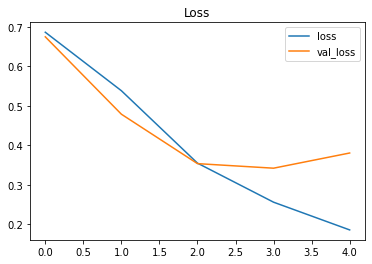

In [ ]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()
plt.show()


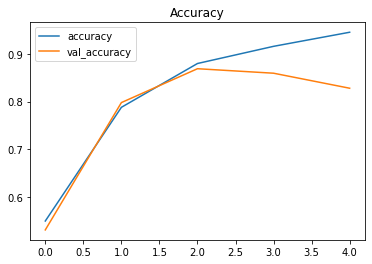

In [ ]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

# 7.3 Other recurrent layers implemented in keras

*  LSTM
*  Bidirectional(LSTM)
*  GRU

**Long-Term Short Term Memory LSTM networks**

You may read about LSTM networks You may read about LSTM networks [in this article](https://medium.com/analytics-vidhya/in-depth-tutorial-of-recurrent-neural-network-rnn-and-long-short-term-memory-lstm-networks-3a782712a09f). 


*LSTM is a special kind of RNN which is mainly useful for learning long-term dependencies. The name refers to the idea that the activations of a network correspond to short-term memory, while the weights correspond to long-term memory. If the activations can preserve information over long distances, that makes them long-term short-term memory.*

**Bidirectional**

*The idea of Bidirectional Recurrent Neural Networks (RNNs) is straightforward. It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.*

[Open the artice...](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs,-The%20idea%20of&text=It%20involves%20duplicating%20the%20first,input%20sequence%20to%20the%20second.)


**Gated Recurrent Unit - GRU**
Citing [Wikipedia](https://en.wikipedia.org/wiki/Gated_recurrent_unit)

*Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate.GRU's performance on certain tasks of polyphonic music modeling, speech signal modeling and natural language processing was found to be similar to that of LSTM. GRUs have been shown to exhibit better performance on certain smaller and less frequent datasets*


We will define a few sample configurations and a a function `build_recurrent_model` that will build a model 
inserting a recurrent layer passed as a parameter


In [ ]:
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import GRU

configurations=[
    {'recurrent_layer':SimpleRNN(units = 16,return_sequences=True),'embedding_dim':32,'epochs':10},
    {'recurrent_layer':LSTM(units = 32,return_sequences=True),'embedding_dim':64,'epochs':10},
    {'recurrent_layer':Bidirectional(LSTM(units = 32,return_sequences=True)),'embedding_dim':64,'epochs':3},
    {'recurrent_layer':GRU(units = 32,return_sequences=True),'embedding_dim':64,'epochs':3},
]

def build_recurrent_model(embedding_dim, recurrent_layer):
  model= Sequential()
  model.add(Embedding(input_dim=10_000, output_dim=embedding_dim, input_length=maxlen))
  model.add(recurrent_layer)  
  model.add(GlobalMaxPool1D())  
  model.add(Dense(20, activation="relu"))
  model.add(Dropout(0.05))
  model.add(Dense(2, activation='softmax'))
  # model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  # model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  return model



**TODO 7.3.1** Prepare at least four similar configurations using `SimpleRNN`, `LSTM`, `Bidirectional` and `GRU` layers. 
Each of basic configurations should be tested (or cross-validated). As a rule - you may use a configuration with 
smaller number of epochs for CV (cross-validation) and copy it entering greater nummber of epochs (for tetsing).

In [ ]:
model1 = build_recurrent_model((configurations[0])["embedding_dim"], (configurations[0])["recurrent_layer"])
epochs = (configurations[0])["epochs"]
batch_size = 1050
hist1 = model1.fit(seq_train_padded, df_train.label, epochs = epochs, batch_size = batch_size, validation_split = 0.2)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 500, 32)           320000    
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 500, 16)           784       
                                                                 
 global_max_pooling1d_10 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_20 (Dense)            (None, 20)                340       
                                                                 
 dropout_10 (Dropout)        (None, 20)                0         
                                                                 
 dense_21 (Dense)            (None, 2)                 42        
                                                     

              precision    recall  f1-score   support

           0       0.80      0.81      0.81     12258
           1       0.82      0.80      0.81     12742

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



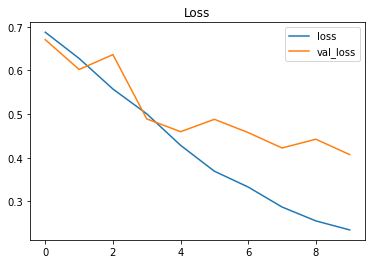

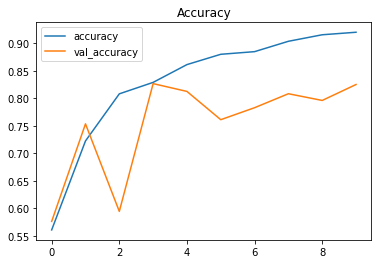

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

probs = model1.predict(seq_test_padded)
y_pred = np.argmax(probs,axis=1)
print( classification_report(y_pred,df_test.label))

plt.title('Loss')
plt.plot(hist1.history['loss'],label='loss')
plt.plot(hist1.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(hist1.history['accuracy'],label='accuracy')
plt.plot(hist1.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
model2 = build_recurrent_model((configurations[1])["embedding_dim"], (configurations[1])["recurrent_layer"])
epochs = (configurations[1])["epochs"]
batch_size = 512
hist2 = model2.fit(seq_train_padded, df_train.label, epochs = epochs, batch_size = batch_size, validation_split = 0.2)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 500, 64)           640000    
                                                                 
 lstm_12 (LSTM)              (None, 500, 32)           12416     
                                                                 
 global_max_pooling1d_11 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_22 (Dense)            (None, 20)                660       
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_23 (Dense)            (None, 2)                 42        
                                                     

              precision    recall  f1-score   support

           0       0.85      0.82      0.84     12945
           1       0.82      0.85      0.83     12055

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



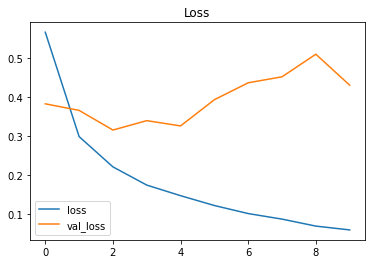

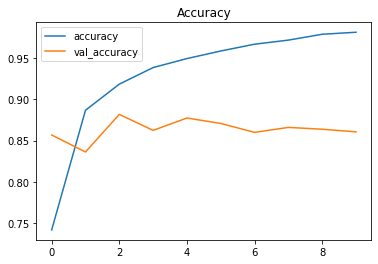

In [ ]:
probs = model2.predict(seq_test_padded)
y_pred = np.argmax(probs,axis=1)
print( classification_report(y_pred,df_test.label))

plt.title('Loss')
plt.plot(hist2.history['loss'],label='loss')
plt.plot(hist2.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(hist2.history['accuracy'],label='accuracy')
plt.plot(hist2.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
model3 = build_recurrent_model((configurations[2])["embedding_dim"], (configurations[2])["recurrent_layer"])
epochs = (configurations[2])["epochs"]
batch_size = 256
hist3 = model3.fit(seq_train_padded, df_train.label, epochs = epochs, batch_size = batch_size, validation_split = 0.2)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 500, 64)           640000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 global_max_pooling1d_15 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_30 (Dense)            (None, 20)                1300      
                                                                 
 dropout_15 (Dropout)        (None, 20)                0         
                                                                 
 dense_31 (Dense)            (None, 2)               

              precision    recall  f1-score   support

           0       0.84      0.87      0.86     12166
           1       0.87      0.85      0.86     12834

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



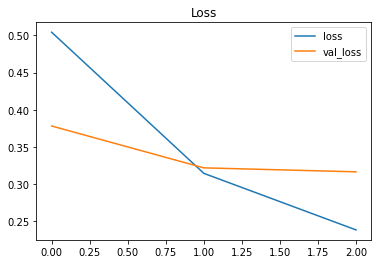

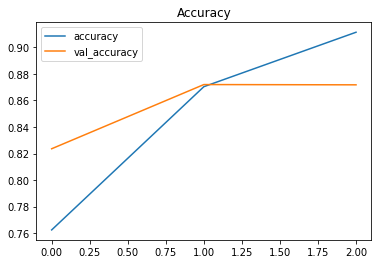

In [ ]:
probs = model3.predict(seq_test_padded)
y_pred = np.argmax(probs,axis=1)
print( classification_report(y_pred,df_test.label))

plt.title('Loss')
plt.plot(hist3.history['loss'],label='loss')
plt.plot(hist3.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(hist3.history['accuracy'],label='accuracy')
plt.plot(hist3.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
model4 = build_recurrent_model((configurations[3])["embedding_dim"], (configurations[3])["recurrent_layer"])
epochs = (configurations[3])["epochs"]
batch_size = 1050
hist4 = model4.fit(seq_train_padded, df_train.label, epochs = epochs, batch_size = batch_size, validation_split = 0.2)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 500, 64)           640000    
                                                                 
 gru_6 (GRU)                 (None, 500, 32)           9408      
                                                                 
 global_max_pooling1d_17 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_34 (Dense)            (None, 20)                660       
                                                                 
 dropout_17 (Dropout)        (None, 20)                0         
                                                                 
 dense_35 (Dense)            (None, 2)                 42        
                                                     

              precision    recall  f1-score   support

           0       0.93      0.76      0.83     15339
           1       0.70      0.91      0.79      9661

    accuracy                           0.82     25000
   macro avg       0.82      0.83      0.81     25000
weighted avg       0.84      0.82      0.82     25000



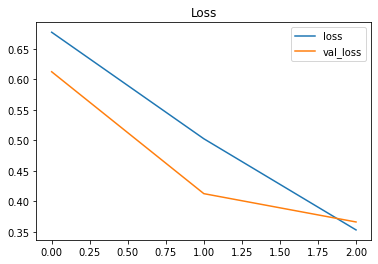

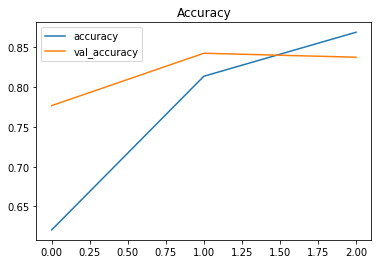

In [ ]:
probs = model4.predict(seq_test_padded)
y_pred = np.argmax(probs,axis=1)
print( classification_report(y_pred,df_test.label))

plt.title('Loss')
plt.plot(hist4.history['loss'],label='loss')
plt.plot(hist4.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(hist4.history['accuracy'],label='accuracy')
plt.plot(hist4.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

## 7.3.1 Using scikit learn compatiblie keras wrapper

We will try KerasClassifier, which can be used within scikit-learn pipelines and functions for hyperparameter selection (e.g. `GridSearchCV`) 

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
#or
#!pip install scikeras tensorflow
#from scikeras.wrappers import KerasClassifier


In [ ]:
config = configurations[2]

classifier = KerasClassifier(build_fn = lambda : build_recurrent_model(
    embedding_dim=config['embedding_dim'],
    recurrent_layer=config['recurrent_layer']),
    epochs=config['epochs'],
    batch_size=256)

classifier.fit(seq_train_padded,df_train.label)
y_pred = classifier.predict(seq_test_padded)
print(classification_report(y_pred,df_test.label))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  import sys


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 500, 64)           640000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 global_max_pooling1d_18 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_36 (Dense)            (None, 20)                1300      
                                                                 
 dropout_18 (Dropout)        (None, 20)                0         
                                                                 
 dense_37 (Dense)            (None, 2)               

## 7.3.2 Applying cross-validation

We will demonstrate cross-vaildation using `cross_vaildate` function.

**TODO 7.3.2** Apply CV for 4 basic configurations with a small number of epochs (e.g.3) and number of folds (also 3). Use training dataset in cross validation.

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [ ]:
from sklearn.model_selection import cross_validate
import numpy as np

row_list = []
names = ["SimpleRNN",
         "LSTM",
         "Bidirectional",
         "GRU"   
]

for i in [0, 1, 2, 3]:
  config = configurations[i]
  classifier = KerasClassifier(build_fn = lambda : build_recurrent_model(
      embedding_dim=config['embedding_dim'],
      recurrent_layer=config['recurrent_layer']),
      epochs=3,
      batch_size=256)
  n_cv_folds = 3
  scoring = ['accuracy','precision_macro','recall_macro','f1_macro','roc_auc', "completeness_score"]
  results = cross_validate(classifier, seq_train_padded,df_train.label, 
                           cv=n_cv_folds, scoring=scoring,return_train_score=True)
  print(results)
  row_list.append([names[i],np.mean(results["test_completeness_score"]), np.mean(results['test_accuracy']),np.mean(results['test_precision_macro']),np.mean(results['test_recall_macro']),np.mean(results['test_f1_macro'])])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 500, 32)           320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 500, 16)           784       
                                                                 
 global_max_pooling1d_13 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_26 (Dense)            (None, 20)                340       
                                                                 
 dropout_13 (Dropout)        (None, 20)                0         
                                                                 
 dense_27 (Dense)            (None, 2)                 42        
                                                     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/3
66/66 [==============================] - 44s 647ms/step - loss: 0.5683 - accuracy: 0.7118
Epoch 2/3
66/66 [==============================] - 42s 638ms/step - loss: 0.4060 - accuracy: 0.8354
Epoch 3/3
66/66 [==============================] - 42s 637ms/step - loss: 0.3283 - accuracy: 0.8759
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 500, 32)           320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 500, 16)           784       
                                                                 
 global_max_pooling1d_14 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_28 (Dense)            (None, 20)                340       
                 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 500, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 500, 32)           12416     
                                                                 
 global_max_pooling1d_16 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_32 (Dense)            (None, 20)                660       
                                                                 
 dropout_16 (Dropout)        (None, 20)                0         
                                                                 
 dense_33 (Dense)            (None, 2)                 42        
                                                     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 500, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          24832     
 l)                                                              
                                                                 
 global_max_pooling1d_19 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_38 (Dense)            (None, 20)                1300      
                                                                 
 dropout_19 (Dropout)        (None, 20)                0         
                                                                 
 dense_39 (Dense)            (None, 2)               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 500, 64)           640000    
                                                                 
 gru (GRU)                   (None, 500, 32)           9408      
                                                                 
 global_max_pooling1d_22 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_44 (Dense)            (None, 20)                660       
                                                                 
 dropout_22 (Dropout)        (None, 20)                0         
                                                                 
 dense_45 (Dense)            (None, 2)                 42        
                                                     

In [ ]:
df_results = pd.DataFrame(results)
df_results.head()

,fit_time,score_time,test_accuracy,train_accuracy,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_roc_auc,train_roc_auc,test_completeness_score,train_completeness_score
0,21.685137,17.586535,0.871850,0.953738,0.872543,0.954426,0.871887,0.953722,0.871798,0.953719,0.945090,0.988492,0.449990,0.735674
1,22.264630,17.590737,0.850234,0.922662,0.863850,0.930029,0.849781,0.922815,0.848700,0.922347,0.948684,0.989587,0.431463,0.654215
2,22.954191,17.589643,0.852154,0.942701,0.862443,0.945371,0.851618,0.942826,0.850956,0.942626,0.941155,0.988061,0.425821,0.704653


**TODO 7.3.3** For each configuration tested - collect scores, compute mean values and finaly prepare a table summarizing the results. Expected four rows (results for a configuration in one row). 

In [ ]:
import pandas as pd
df = pd.DataFrame(row_list,columns=["recurrent network type","score", 'accuracy', 'precision', 'recall', 'f1'])
df.head(df.size)

,recurrent network type,score,accuracy,precision,recall,f1
0,SimpleRNN,0.358425,0.808164,0.834733,0.808023,0.800887
1,LSTM,0.452687,0.870320,0.872917,0.870370,0.870105
2,Bidirectional,0.460699,0.871400,0.875545,0.871398,0.871035
3,GRU,0.435758,0.858079,0.866278,0.857762,0.857152


**TODO 7.3.4** Select two most promising configurations for testing (based on accuracy or F1). Apply more epochs. During thesting use the test dataset. Gather the results in a table (two rows), giving:
*  name of the configuration
*  recurrent network type
*  number of epochs
*  main scores 

In [ ]:
from sklearn.model_selection import cross_validate
import numpy as np

row_list = []
names = ["SimpleRNN",
         "LSTM",
         "Bidirectional",
         "GRU"   
]
configuration = ["Config 1",
         "Config 2",
         "Config 3",
         "Config 4"          
]

epochs=10
for i in [1, 2]:
  config = configurations[i]
  classifier = KerasClassifier(build_fn = lambda : build_recurrent_model(
      embedding_dim=config['embedding_dim'],
      recurrent_layer=config['recurrent_layer']),
      epochs=epochs,
      batch_size=256)
  n_cv_folds = 3
  scoring = ['accuracy','precision_macro','recall_macro','f1_macro','roc_auc', "completeness_score"]
  results = cross_validate(classifier, seq_train_padded,df_test.label, 
                           cv=n_cv_folds, scoring=scoring,return_train_score=True)
  print(results)
  row_list.append([configuration[i],names[i],epochs,np.mean(results["test_completeness_score"]), np.mean(results['test_accuracy']),np.mean(results['test_precision_macro']),np.mean(results['test_recall_macro']),np.mean(results['test_f1_macro'])])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 500, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 500, 32)           12416     
                                                                 
 global_max_pooling1d_28 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_56 (Dense)            (None, 20)                660       
                                                                 
 dropout_28 (Dropout)        (None, 20)                0         
                                                                 
 dense_57 (Dense)            (None, 2)                 42        
                                                     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 500, 64)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          24832     
 l)                                                              
                                                                 
 global_max_pooling1d_31 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_62 (Dense)            (None, 20)                1300      
                                                                 
 dropout_31 (Dropout)        (None, 20)                0         
                                                                 
 dense_63 (Dense)            (None, 2)               

In [ ]:
import pandas as pd
df = pd.DataFrame(row_list,columns=["configuration","recurrent network type","epochs","score", 'accuracy', 'precision', 'recall', 'f1'])
df.head(df.size)

,configuration,recurrent network type,epochs,score,accuracy,precision,recall,f1
0,Config 2,LSTM,10,0.000039,0.49772,0.496911,0.496980,0.491918
1,Config 3,Bidirectional,10,0.000153,0.49676,0.497439,0.497816,0.488791


## 7.3.3 Conv1D - sequence procesing based on 1D convolutions

In [15]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop


model = Sequential()
model.add(layers.Embedding(input_dim=10_000, output_dim=128, input_length=maxlen))
model.add(layers.Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=5))
model.add(layers.Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4),
                                loss='binary_crossentropy',
                                metrics=['accuracy'])
hist = model.fit(seq_train_padded,df_train.label, epochs=20, batch_size=128,  validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_6 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 1)                

**TODO** Compute and display scores for the test set

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
probs = model.predict(seq_test_padded)
y_pred = np.argmax(probs,axis=1)
print(classification_report(y_pred,df_test.label))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67     25000
           1       0.00      0.00      0.00         0

    accuracy                           0.50     25000
   macro avg       0.50      0.25      0.33     25000
weighted avg       1.00      0.50      0.67     25000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**TODO 7.3.5** Plot values in the history

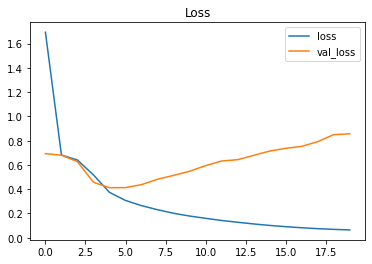

In [ ]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

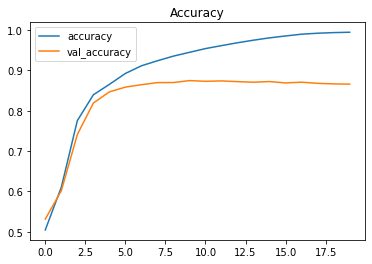

In [ ]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

# 7.4 Regression - bike sharing dataset 

We will use a dataset containing information on bike rentals. We will focus on the attribute `cnt` collected every hour. 

In [18]:
!wget https://dysk.agh.edu.pl/s/G6ZNziBRbEEcMeN/download -O Bike-Sharing-Dataset.zip
!unzip Bike-Sharing-Dataset.zip
!cat Readme.txt

--2022-05-06 14:10:09--  https://dysk.agh.edu.pl/s/G6ZNziBRbEEcMeN/download
Resolving dysk.agh.edu.pl (dysk.agh.edu.pl)... 149.156.96.4, 2001:6d8:10:1060::6004
Connecting to dysk.agh.edu.pl (dysk.agh.edu.pl)|149.156.96.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/zip]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K   474KB/s    in 0.6s    

2022-05-06 14:10:11 (474 KB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                
Bike Sharing Dataset

Hadi Fanaee-T

Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto
INESC Porto, Campus da FEUP
Rua Dr. Roberto Frias, 378
4200 - 465 Porto, Portugal


Background 

Bike sharing systems are new generation of traditional bike rentals where whole process from member

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('hour.csv',parse_dates=['dteday'])
df.head(len(df))

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


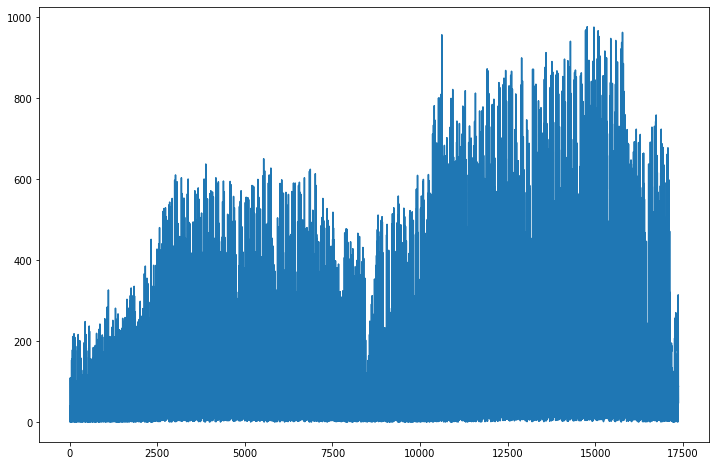

In [20]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(df.cnt)


Let us plot some examples for time intervals corresponding to two weeks. Visible fluctuations with 7 days and 24 periods.

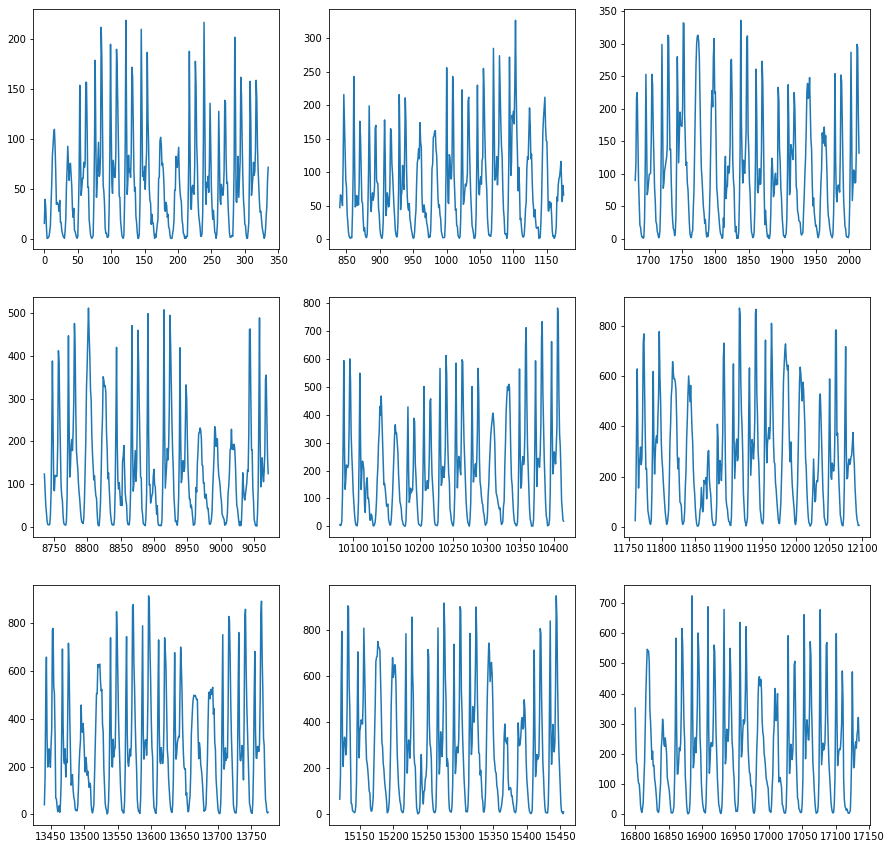

In [21]:
import numpy as np

starts = np.array([0,5*7*24,10*7*24, 52*7*24, 60*7*24,70*7*24,80*7*24,90*7*24,100*7*24]) 
subplots = [df.cnt[starts[i]:starts[i]+14*24] for i in range(len(starts))]

fig = plt.figure(figsize=(15, 15))
for i in range(9):
  ax = fig.add_subplot(3,3, 1 + i)
  ax.plot(subplots[i])
  # if title is not None:
  #   plt.suptitle(title)
plt.show()


## Problem statement


We will use only a sequence of `cnt` values - let us dentoe it as $[x(0),x(1), \dots,x(n)]$. 

Our idea is to predict the target value in the feature based on a sequence registered recently in the past. 

Let $t$ be a current discrete time. 
*  $x(t+h)$ is a target value to be predicted. $h>=1$ stands for *horizon*
*  $[x(t-w),x(t-w+1),\dots,x(t)]$ is a subsequence used for making predictions. It starts at $x(t-w)$ and ends at the current value $x(t)$. The parameter $w$ stands for *window size*.

In our problem statement we select:
* $h$ (horizon) equals to one week
* $w$  (window size) equals to two weeks

So, we predict one week ahead.


## 7.4.1 Generator



The generator fiunction will yield a tuple `(samples, targets)` where `samples` is one batch of input data and `targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `window_size`: How many timesteps back should our input data go.
* `horizon`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.
* `expand_dims` wrap 2D arrays as 3D tensors.

In [22]:
import sklearn

def generator(data, window_size, horizon, min_index, max_index, shuffle=False, batch_size=128, step=1,expand_dims=False):
  if max_index is None:
    max_index = len(data) - 1 
  cursor = min_index + window_size
  while 1:
      if cursor + batch_size + horizon > max_index:
          cursor = min_index + window_size
      
      rows = np.arange(cursor, min(cursor + batch_size, max_index))
      cursor += len(rows)

      samples = np.zeros((len(rows), window_size // step))
      targets = np.zeros((len(rows),))
      for j, row in enumerate(rows):
          indices = np.arange(rows[j] - window_size, rows[j], step,dtype=int)
          samples[j] = data[indices]
          targets[j] = data[rows[j] + horizon-1]
      if shuffle:
        samples,targets = sklearn.utils.shuffle(samples,targets)
      if expand_dims:
        samples = np.expand_dims(samples,axis=-1)
        # targets = np.expand_dims(targets,axis=-1)
      yield samples, targets

### Some tests for demonstration

In [23]:
x=np.arange(3000)
gen = generator(x,10,10,min_index=0, max_index=70,batch_size = 5,shuffle=False)
for i,(x,y) in enumerate(gen):
  print(i,x,y)
  if i== 10: break

0 [[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
 [ 4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]] [19. 20. 21. 22. 23.]
1 [[ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
 [ 6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
 [ 7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
 [ 8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]
 [ 9. 10. 11. 12. 13. 14. 15. 16. 17. 18.]] [24. 25. 26. 27. 28.]
2 [[10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
 [11. 12. 13. 14. 15. 16. 17. 18. 19. 20.]
 [12. 13. 14. 15. 16. 17. 18. 19. 20. 21.]
 [13. 14. 15. 16. 17. 18. 19. 20. 21. 22.]
 [14. 15. 16. 17. 18. 19. 20. 21. 22. 23.]] [29. 30. 31. 32. 33.]
3 [[15. 16. 17. 18. 19. 20. 21. 22. 23. 24.]
 [16. 17. 18. 19. 20. 21. 22. 23. 24. 25.]
 [17. 18. 19. 20. 21. 22. 23. 24. 25. 26.]
 [18. 19. 20. 21. 22. 23. 24. 25. 26. 27.]
 [19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]] [34. 35. 36. 37. 38.]
4 [[20. 21. 22. 23. 24. 25. 26. 27. 28. 

### Data preparation and configuration of generators

*  We selected that an inital sequence o 12000 readings wil be used for training and the rest for testing
*  Data are normalized with `StandardScaler`

**Note** in further experiments we will repat cells initializing the generators. They start at the first index and then they wrap over the end to the beginning.

In [24]:
x_orig = df.cnt.to_numpy()
from sklearn.preprocessing import StandardScaler
x=x_orig.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(x[:12_000])
x_scaled=scaler.transform(x)
x_scaled=x_scaled.reshape(-1)
print(x_scaled)

[-0.94185161 -0.78331641 -0.83616147 ... -0.45303472 -0.6445981
 -0.7238657 ]


In [25]:
window_size = 14*24
horizon = 7*24
batch_size=128
train_gen = generator(x_scaled,
                      window_size=window_size,
                      horizon=horizon,
                      min_index=0,
                      max_index=12_000,
                      shuffle=False,
                      step=1, 
                      batch_size=batch_size)
val_gen = generator(x_scaled,
                     window_size=window_size,
                     horizon=horizon,
                     min_index=12_000,
                     max_index=None,
                     shuffle=False,
                     step=1, 
                     batch_size=batch_size)

train_steps = (12_000-window_size-horizon-batch_size)//window_size
print(train_steps)

val_steps = (x_scaled.size-12_000-window_size-horizon-batch_size)//window_size
print(val_steps)


33
14


## 7.4.2 Basic architecture

The basic architecture uses the whole input sequence at one to make the prediction.

In [ ]:
from keras.models import Sequential
from keras import layers
import tensorflow
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

seed=42
np.random.seed(seed)
tf.random.set_seed(seed)


model = Sequential()
model.add(layers.Dense(units=64,input_shape=(window_size,)))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(1))

# model .compile(optimizer=RMSprop(learning_rate=0.0001), loss='mse', metrics=['mse','mae'])
model .compile(optimizer='adam', loss='mse', metrics=['mse','mae'])
model.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                21568     
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 23,681
Trainable params: 23,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(train_gen,steps_per_epoch=train_steps,epochs=20,batch_size=batch_size,
                                                validation_data=val_gen,
                                                validation_steps=val_steps)



Epoch 1/20
33/33 [==============================] - 1s 12ms/step - loss: 0.8096 - mse: 0.8096 - mae: 0.6963 - val_loss: 2.8513 - val_mse: 2.8513 - val_mae: 1.3863
Epoch 2/20
33/33 [==============================] - 0s 8ms/step - loss: 0.9697 - mse: 0.9697 - mae: 0.7411 - val_loss: 14.9918 - val_mse: 14.9918 - val_mae: 3.5728
Epoch 3/20
33/33 [==============================] - 0s 8ms/step - loss: 1.1731 - mse: 1.1731 - mae: 0.8333 - val_loss: 3.7284 - val_mse: 3.7284 - val_mae: 1.5599
Epoch 4/20
33/33 [==============================] - 0s 8ms/step - loss: 0.5633 - mse: 0.5633 - mae: 0.5769 - val_loss: 11.5595 - val_mse: 11.5595 - val_mae: 3.1248
Epoch 5/20
33/33 [==============================] - 0s 7ms/step - loss: 0.5715 - mse: 0.5715 - mae: 0.5725 - val_loss: 9.0914 - val_mse: 9.0914 - val_mae: 2.5725
Epoch 6/20
33/33 [==============================] - 0s 10ms/step - loss: 1.0152 - mse: 1.0152 - mae: 0.7612 - val_loss: 4.8532 - val_mse: 4.8532 - val_mae: 2.0033
Epoch 7/20
33/33 [====

To test on the remaining data, we will configure a test generator, which produces batches containing one single element. The sizes of predicted values `y_pred` and test values `y_test` should match.

In [ ]:
test_gen = generator(x_scaled,
                     window_size=window_size,
                     horizon=horizon,
                     min_index=12_000,
                     max_index=None,
                     shuffle=False,
                     step=1, 
                     batch_size=1)

steps = len(x_scaled)-12_000

y_pred = model.predict(test_gen,steps=steps)
print(y_pred.shape)
y_pred = y_pred.reshape(-1)
print(y_pred.shape)

(5379, 1)
(5379,)


In [ ]:
y_test = x_scaled[12_000:]
print(y_test.shape)
# print(y_test)

(5379,)


We will compute some basic regression scores. Analuyuzing `r2` (determination coefficient) predictive capabilities of our model are not that great.

In [ ]:
import sklearn.metrics

def compute_scores(y_test,y_pred):
  scores={'r2':sklearn.metrics.r2_score,
        'mse':sklearn.metrics.mean_squared_error,
        'rmse':lambda y_true,y_pred : np.sqrt(sklearn.metrics.mean_squared_error(y_true,y_pred)),
        'maxe':sklearn.metrics.max_error,
        'med':sklearn.metrics.median_absolute_error,
        'mae':sklearn.metrics.mean_absolute_error,
        'mape':sklearn.metrics.mean_absolute_percentage_error,
        }
  results={}
  for k in scores:
    results[k] = scores[k](y_test,y_pred)
  return results

r = compute_scores(y_test,y_pred)
print(r)

{'r2': 0.3280783644724097, 'mse': 1.4159535979442306, 'rmse': 1.1899384849412302, 'maxe': 6.292472213935831, 'med': 0.5806621909479992, 'mae': 0.8538530660898132, 'mape': 2.5945003649803056}


To prepare plots in original units, we must apply inverse transformation to that introduced by the scaler.

In [ ]:
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_orig = y_test_orig.reshape(-1)
y_pred_orig = y_pred_orig.reshape(-1)
# print(y_test_orig.shape)


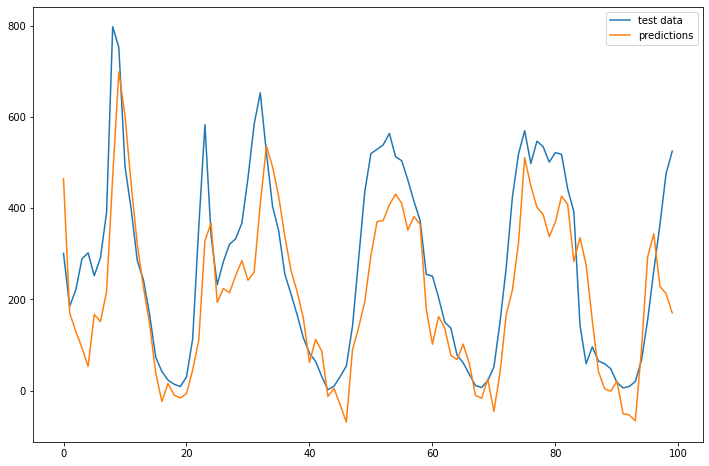

In [ ]:
plt.plot(y_test_orig[100:200],label='test data')
plt.plot(y_pred_orig[100:200],label='predictions')
plt.legend()
plt.show()

## 7.4.3 GRU

We will apply a basic GRU configuration.

**TODO 7.4.1** Make the model more complex, eg. increas a number of units and introduce a smal dense layer. 

In [ ]:
from keras.models import Sequential
from keras import layers
#from keras.optimizers import RMSprop
import tensorflow
from tensorflow.keras.optimizers import RMSprop

model  = Sequential()

model.add(layers.GRU(units = 64, input_shape=(None,window_size)))
model.add(layers.Dense(units=32,input_shape=(window_size,)))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mse', metrics=['mse','mae'])
model.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                77184     
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 79,297
Trainable params: 79,297
Non-trainable params: 0
_________________________________________________________________


In this case we applied `expand_dims` option - to convert 2D matrix `batch_size x window_size` into `batch_size x window_size x features`. The number of features is 1.  

In [ ]:
train_gen = generator(x_scaled,
                      window_size=window_size,
                      horizon=horizon,
                      min_index=0,
                      max_index=12_000,
                      shuffle=False,
                      step=1, 
                      batch_size=batch_size,
                      expand_dims=True)
val_gen = generator(x_scaled,
                     window_size=window_size,
                     horizon=horizon,
                     min_index=12_000,
                     max_index=None,
                     shuffle=False,
                     step=1, 
                     batch_size=batch_size,
                     expand_dims=True)
train_steps = (12_000-window_size-horizon-batch_size)//window_size
print(train_steps)

val_steps = (x_scaled.size-12_000-window_size-horizon-batch_size)//window_size
print(val_steps)

33
14


In [ ]:
X,y = next(train_gen)
print(X.shape)

(128, 336, 1)


In [ ]:
hist = model.fit(train_gen,steps_per_epoch=train_steps,
                                            epochs=20,
                                            batch_size=batch_size,
                                            validation_data=val_gen,
                                            validation_steps=val_steps)


Epoch 1/20
33/33 [==============================] - 5s 93ms/step - loss: 0.3464 - mse: 0.3464 - mae: 0.4531 - val_loss: 0.5697 - val_mse: 0.5697 - val_mae: 0.5072
Epoch 2/20
33/33 [==============================] - 3s 77ms/step - loss: 0.4206 - mse: 0.4206 - mae: 0.4458 - val_loss: 1.5201 - val_mse: 1.5201 - val_mae: 0.9181
Epoch 3/20
33/33 [==============================] - 3s 77ms/step - loss: 0.5171 - mse: 0.5171 - mae: 0.5170 - val_loss: 0.6432 - val_mse: 0.6432 - val_mae: 0.5569
Epoch 4/20
33/33 [==============================] - 3s 78ms/step - loss: 0.3553 - mse: 0.3553 - mae: 0.3891 - val_loss: 0.9206 - val_mse: 0.9206 - val_mae: 0.7109
Epoch 5/20
33/33 [==============================] - 3s 78ms/step - loss: 0.3484 - mse: 0.3484 - mae: 0.4136 - val_loss: 0.9540 - val_mse: 0.9540 - val_mae: 0.6787
Epoch 6/20
33/33 [==============================] - 3s 79ms/step - loss: 0.4510 - mse: 0.4510 - mae: 0.4776 - val_loss: 0.4336 - val_mse: 0.4336 - val_mae: 0.4420
Epoch 7/20
33/33 [====

**TODO 7.4.2** Display the history content

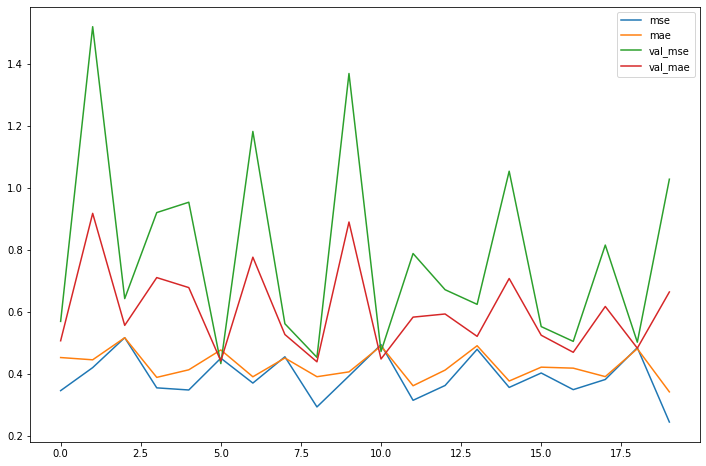

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['mse'],label='mse')
plt.plot(hist.history['mae'],label='mae')
plt.plot(hist.history['val_mse'],label='val_mse')
plt.plot(hist.history['val_mae'],label='val_mae')
plt.legend()
plt.show()

**TODO 7.4.3** Convert predictions to original range of values and plot an interesting part. The example plots show predictions from the range [100:200]

In [ ]:
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_orig = y_test_orig.reshape(-1)
y_pred_orig = y_pred_orig.reshape(-1)

In [ ]:
r = compute_scores(y_test,y_pred)
print(r)

{'r2': 0.3280783644724097, 'mse': 1.4159535979442306, 'rmse': 1.1899384849412302, 'maxe': 6.292472213935831, 'med': 0.5806621909479992, 'mae': 0.8538530660898132, 'mape': 2.5945003649803056}


In [ ]:
r = compute_scores(y_test_orig,y_pred_orig)
print(r)

{'r2': 0.328078360260983, 'mse': 32450.40011257065, 'rmse': 180.13994591031343, 'maxe': 952.5917673110962, 'med': 87.90408325195312, 'mae': 129.26134158343183, 'mape': 2.3613374147073674}


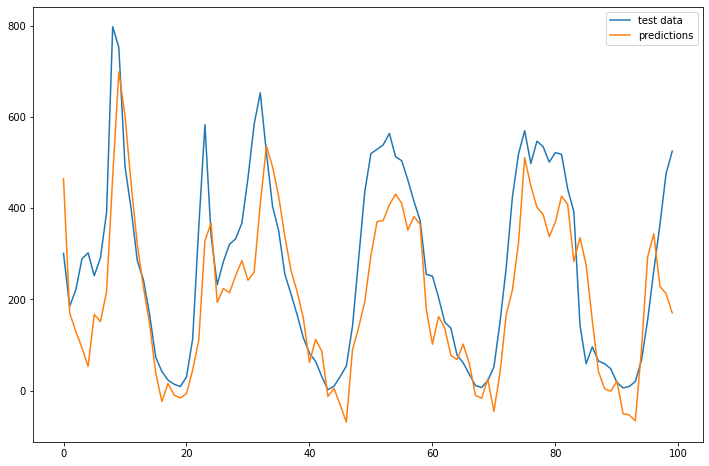

In [ ]:
plt.plot(y_test_orig[100:200],label='test data')
plt.plot(y_pred_orig[100:200],label='predictions')
plt.legend()
plt.show()

## 7.4.4 Stacked GRU

This is rateher a time-demanding configuration, therefor we will train it during a few epochs.

In [26]:
from keras.models import Sequential
from keras import layers
#from keras.optimizers import RMSprop
import tensorflow
from tensorflow.keras.optimizers import RMSprop
from keras.layers import BatchNormalization
from keras import regularizers

model  = Sequential()
model.add(layers.GRU(32,  dropout=0.05,
                          recurrent_dropout=0.05,
                          return_sequences=True,
                          input_shape=(window_size,1),
                          kernel_regularizer=regularizers.l2(0.001)))
model .add(layers.GRU(64, activation='relu',
                          dropout=0.05, 
                          recurrent_dropout=0.05,
                          kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae',metrics=['mse','mae'])


In [27]:
train_gen = generator(x_scaled,
                      window_size=window_size,
                      horizon=horizon,
                      min_index=0,
                      max_index=12_000,
                      shuffle=False,
                      step=1, 
                      batch_size=batch_size,
                      expand_dims=True)
val_gen = generator(x_scaled,
                     window_size=window_size,
                     horizon=horizon,
                     min_index=12_000,
                     max_index=None,
                     shuffle=False,
                     step=1, 
                     batch_size=batch_size,
                     expand_dims=True)
train_steps = (12_000-window_size-horizon-batch_size)//window_size
print(train_steps)

val_steps = (x_scaled.size-12_000-window_size-horizon-batch_size)//window_size
print(val_steps)

33
14


In [28]:
hist = model.fit(train_gen,steps_per_epoch=train_steps,
                                            epochs=5,
                                            batch_size=batch_size,
                                            validation_data=val_gen,
                                            validation_steps=val_steps)

Epoch 1/5
33/33 [==============================] - 111s 3s/step - loss: 0.5757 - mse: 0.5268 - mae: 0.5328 - val_loss: 0.6728 - val_mse: 0.9484 - val_mae: 0.6369
Epoch 2/5
33/33 [==============================] - 107s 3s/step - loss: 0.5116 - mse: 0.5019 - mae: 0.4799 - val_loss: 1.1774 - val_mse: 2.0265 - val_mae: 1.1496
Epoch 3/5
33/33 [==============================] - 105s 3s/step - loss: 0.5489 - mse: 0.5922 - mae: 0.5234 - val_loss: 0.6750 - val_mse: 0.7679 - val_mae: 0.6516
Epoch 4/5
33/33 [==============================] - 106s 3s/step - loss: 0.4549 - mse: 1.5251 - mae: 0.4330 - val_loss: 0.5477 - val_mse: 0.6810 - val_mae: 0.5265
Epoch 5/5
33/33 [==============================] - 105s 3s/step - loss: 0.4193 - mse: 0.3785 - mae: 0.3987 - val_loss: 0.7250 - val_mse: 1.0728 - val_mae: 0.7053


**TODO 7.4.3** Testing with `batch_size=1` is rather a long process. 

*  Configure `test_gen` to produce larger batches. 
*  Compute a number of steps to be done to cover testing data [12000:]
*  Some data at the end will not be tested
*  Select appropriate subsequence of `x_scaled`
*  Compute scores  

In [31]:
steps = len(x_scaled)-12_000
test_gen = generator(x_scaled,
                     window_size=window_size,
                     horizon=horizon,
                     min_index=12_000,
                     max_index=None,
                     shuffle=False,
                     step=1, 
                     batch_size=1)
y_pred = model.predict(test_gen,steps=steps,verbose=1)
y_pred = y_pred.reshape(-1)
print(y_pred.shape)

5379/5379 [==============================] - 1260s 234ms/step
(5379,)


In [32]:
y_test = x_scaled[12_000:]
print(y_test.shape)

(5379,)


In [33]:
import sklearn.metrics

def compute_scores(y_test,y_pred):
  scores={'r2':sklearn.metrics.r2_score,
        'mse':sklearn.metrics.mean_squared_error,
        'rmse':lambda y_true,y_pred : np.sqrt(sklearn.metrics.mean_squared_error(y_true,y_pred)),
        'maxe':sklearn.metrics.max_error,
        'med':sklearn.metrics.median_absolute_error,
        'mae':sklearn.metrics.mean_absolute_error,
        'mape':sklearn.metrics.mean_absolute_percentage_error,
        }
  results={}
  for k in scores:
    results[k] = scores[k](y_test,y_pred)
  return results

r = compute_scores(y_test,y_pred)
print(r)

{'r2': 0.28289705115491215, 'mse': 1.5111650627477469, 'rmse': 1.2292945386471652, 'maxe': 6.063255800016727, 'med': 0.547583977014221, 'mae': 0.8415578134750105, 'mape': 2.1690517774244373}


**TODO 7.4.4** Return to the original ranges and plot the data

In [34]:
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_orig = y_test_orig.reshape(-1)
y_pred_orig = y_pred_orig.reshape(-1)

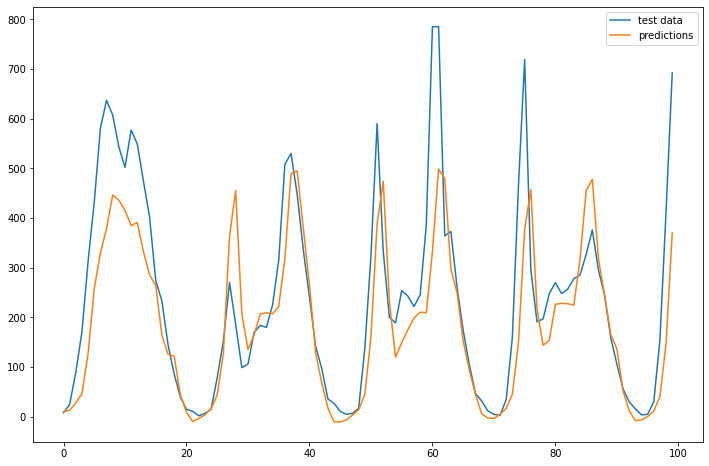

In [35]:
plt.plot(y_test_orig[0:100],label='test data')
plt.plot(y_pred_orig[0:100],label='predictions')
plt.legend()
plt.show()

## 7.4.5 Conv1D - applying 1D convolution

Finally, we will perfom experiment with 1D convolutional filters

In [ ]:
from keras.models import Sequential
from keras import layers
model = Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=7, input_shape=(window_size,1), activation='relu',padding='same'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=7, activation='relu',padding='same'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae',metrics=['mse','mae'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 336, 32)           256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 168, 32)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 168, 64)           14400     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 84, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5376)              0         
                                                                 
 dense_20 (Dense)            (None, 16)              

In [ ]:
train_gen = generator(x_scaled,
                      window_size=window_size,
                      horizon=horizon,
                      min_index=0,
                      max_index=12_000,
                      shuffle=False,
                      step=1, 
                      batch_size=batch_size,
                      expand_dims=True)
val_gen = generator(x_scaled,
                     window_size=window_size,
                     horizon=horizon,
                     min_index=12_000,
                     max_index=None,
                     shuffle=False,
                     step=1, 
                     batch_size=batch_size,
                     expand_dims=True)
train_steps = (12_000-window_size-horizon-batch_size)//window_size
print(train_steps)

val_steps = (x_scaled.size-12_000-window_size-horizon-batch_size)//window_size
print(val_steps)

33
14


In [ ]:
hist = model.fit(train_gen,steps_per_epoch=train_steps,
                                            epochs=20,
                                            batch_size=batch_size,
                                            validation_data=val_gen,
                                            validation_steps=val_steps)

Epoch 1/20
33/33 [==============================] - 1s 22ms/step - loss: 0.5973 - mse: 0.7146 - mae: 0.5973 - val_loss: 1.1570 - val_mse: 2.6307 - val_mae: 1.1570
Epoch 2/20
33/33 [==============================] - 1s 16ms/step - loss: 0.5449 - mse: 0.6583 - mae: 0.5449 - val_loss: 2.2486 - val_mse: 6.6620 - val_mae: 2.2486
Epoch 3/20
33/33 [==============================] - 1s 18ms/step - loss: 0.6960 - mse: 1.0812 - mae: 0.6960 - val_loss: 0.8725 - val_mse: 1.5959 - val_mae: 0.8725
Epoch 4/20
33/33 [==============================] - 0s 15ms/step - loss: 0.5918 - mse: 0.8049 - mae: 0.5918 - val_loss: 1.3067 - val_mse: 3.0761 - val_mae: 1.3067
Epoch 5/20
33/33 [==============================] - 0s 15ms/step - loss: 0.4941 - mse: 0.5438 - mae: 0.4941 - val_loss: 1.1820 - val_mse: 2.5024 - val_mae: 1.1820
Epoch 6/20
33/33 [==============================] - 0s 15ms/step - loss: 0.6865 - mse: 1.0568 - mae: 0.6865 - val_loss: 1.0082 - val_mse: 2.2669 - val_mae: 1.0082
Epoch 7/20
33/33 [====

**TODO 7.4.5** Make predictions, compute regression scores

In [ ]:
test_gen = generator(x_scaled,
                     window_size=window_size,
                     horizon=horizon,
                     min_index=12_000,
                     max_index=None,
                     shuffle=False,
                     step=1, 
                     batch_size=1)
y_pred = model.predict(test_gen,steps=steps)
y_pred = y_pred.reshape(-1)
y_test = x_scaled[12000:]

print(len(y_pred))

5379


In [ ]:
print(len(y_test))

5379


In [ ]:
r = compute_scores(y_test,y_pred)
print(r)

{'r2': 0.37300811374105036, 'mse': 1.3212722589786963, 'rmse': 1.1494660756101922, 'maxe': 5.524128888360777, 'med': 0.6358086630786836, 'mae': 0.8495266487314285, 'mape': 3.386772302546421}


**TODO 7.4.6** Plot the data returning to the original data ranges

In [ ]:
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_orig = y_test_orig.reshape(-1)
y_pred_orig = y_pred_orig.reshape(-1)

In [ ]:
r = compute_scores(y_test_orig,y_pred_orig)
print(r)

{'r2': 0.3730081160516505, 'mse': 30280.52126638027, 'rmse': 174.01299165976164, 'maxe': 836.2753982543945, 'med': 96.25248718261719, 'mae': 128.60638194578056, 'mape': 2.6672553214543573}


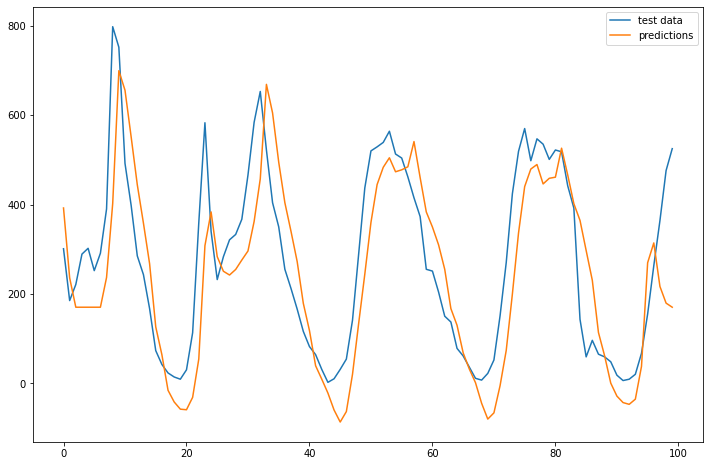

In [ ]:
plt.plot(y_test_orig[100:200],label='test data')
plt.plot(y_pred_orig[100:200],label='predictions')
plt.legend()
plt.show()

In [37]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py

--2022-05-06 14:46:46--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-05-06 14:46:46 (24.5 MB/s) - ‘colab_pdf.py’ saved [1864/1864]



In [38]:
from colab_pdf import colab_pdf
colab_pdf('CI_lab_7.ipynb')

Mounted at /content/drive/




Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/CI_lab_7.ipynb to pdf
[NbConvertApp] Support files will be in CI_lab_7_files/
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_7_files
[NbConvertApp] Making directory ./CI_lab_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'